# Linear models for Gene expression

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import tqdm
from tqdm import tqdm
import scipy.stats as sps
from statsmodels.sandbox.stats.multicomp import multipletests

Thisi notebook is an attempt to reproduce the results of the experiment that was published in [the article](https://pubmed.ncbi.nlm.nih.gov/25049118/). This study aimed to identify prognostic indicators, including individual responses to chemotherapy, in CRC patients. RNA-seq data was generated using 54 samples (normal colon, primary CRC, and liver metastases) from 18 CRC patients and genes associated with CRC aggressiveness were identified.  

In [2]:
raw_data = pd.read_csv("http://genomedata.org/gen-viz-workshop/intro_to_deseq2/tutorial/E-GEOD-50760-raw-counts.tsv", sep = "\t")
raw_data.head()

,Gene ID,Gene Name,SRR975551,SRR975552,SRR975553,SRR975554,SRR975555,SRR975556,SRR975557,SRR975558,...,SRR975595,SRR975596,SRR975597,SRR975598,SRR975599,SRR975600,SRR975601,SRR975602,SRR975603,SRR975604
0,ENSG00000000003,TSPAN6,6617,1352,1492,3390,1464,1251,207,1333,...,2786,1717,1691,6192,722,680,2608,2436,1739,2134
1,ENSG00000000005,TNMD,69,1,20,23,12,4,20,2,...,18,7,10,40,14,1,16,0,2,7
2,ENSG00000000419,DPM1,2798,714,510,1140,1667,322,273,621,...,852,1095,1066,1273,405,597,974,1000,1287,1250
3,ENSG00000000457,SCYL3,486,629,398,239,383,290,164,452,...,244,156,256,422,95,255,331,165,347,349
4,ENSG00000000460,C1orf112,466,342,73,227,193,35,38,184,...,121,105,172,293,73,148,180,160,288,100


In [3]:
sampleData = pd.read_csv("http://genomedata.org/gen-viz-workshop/intro_to_deseq2/tutorial/E-GEOD-50760-experiment-design.tsv",  sep = "\t")
sampleData.head(10)

,Run,Sample Characteristic[biopsy site],Sample Characteristic Ontology Term[biopsy site],Sample Characteristic[disease],Sample Characteristic Ontology Term[disease],Sample Characteristic[disease staging],Sample Characteristic Ontology Term[disease staging],Sample Characteristic[individual],Sample Characteristic Ontology Term[individual],Sample Characteristic[organism],Sample Characteristic Ontology Term[organism],Sample Characteristic[organism part],Sample Characteristic Ontology Term[organism part],Factor Value[biopsy site],Factor Value Ontology Term[biopsy site],Analysed
0,SRR975551,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,colorectal cancer,http://www.ebi.ac.uk/efo/EFO_0005842,Stage IV Colorectal Cancer,NaN,AMC_2,NaN,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,colon,http://purl.obolibrary.org/obo/UBERON_0001155,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,Yes
1,SRR975552,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,colorectal cancer,http://www.ebi.ac.uk/efo/EFO_0005842,Stage IV Colorectal Cancer,NaN,AMC_3,NaN,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,colon,http://purl.obolibrary.org/obo/UBERON_0001155,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,Yes
2,SRR975553,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,colorectal cancer,http://www.ebi.ac.uk/efo/EFO_0005842,Stage IV Colorectal Cancer,NaN,AMC_5,NaN,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,colon,http://purl.obolibrary.org/obo/UBERON_0001155,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,Yes
3,SRR975554,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,colorectal cancer,http://www.ebi.ac.uk/efo/EFO_0005842,Stage IV Colorectal Cancer,NaN,AMC_6,NaN,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,colon,http://purl.obolibrary.org/obo/UBERON_0001155,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,Yes
4,SRR975555,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,colorectal cancer,http://www.ebi.ac.uk/efo/EFO_0005842,Stage IV Colorectal Cancer,NaN,AMC_7,NaN,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,colon,http://purl.obolibrary.org/obo/UBERON_0001155,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,Yes
5,SRR975556,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,colorectal cancer,http://www.ebi.ac.uk/efo/EFO_0005842,Stage IV Colorectal Cancer,NaN,AMC_8,NaN,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,colon,http://purl.obolibrary.org/obo/UBERON_0001155,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,Yes
6,SRR975557,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,colorectal cancer,http://www.ebi.ac.uk/efo/EFO_0005842,Stage IV Colorectal Cancer,NaN,AMC_9,NaN,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,colon,http://purl.obolibrary.org/obo/UBERON_0001155,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,Yes
7,SRR975558,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,colorectal cancer,http://www.ebi.ac.uk/efo/EFO_0005842,Stage IV Colorectal Cancer,NaN,AMC_10,NaN,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,colon,http://purl.obolibrary.org/obo/UBERON_0001155,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,Yes
8,SRR975559,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,colorectal cancer,http://www.ebi.ac.uk/efo/EFO_0005842,Stage IV Colorectal Cancer,NaN,AMC_12,NaN,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,colon,http://purl.obolibrary.org/obo/UBERON_0001155,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,Yes
9,SRR975560,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,colorectal cancer,http://www.ebi.ac.uk/efo/EFO_0005842,Stage IV Colorectal Cancer,NaN,AMC_13,NaN,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,colon,http://purl.obolibrary.org/obo/UBERON_0001155,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,Yes


#### 1. Data Preprocessing



Types of tissue:

In [4]:
sampleData["Sample Characteristic[biopsy site]"].unique()

array(['primary tumor', 'normal',
       'colorectal cancer metastatic in the liver'], dtype=object)

Let's compare TREM1 and CTGF expression in different tissues 

In [5]:
new_data = raw_data[(raw_data['Gene Name']=='TREM1')|(raw_data['Gene Name']=='CTGF')].iloc[:,2:].T
new_data.columns = ['TREM1','CTGF']
new_data['Run'] = new_data.index
new_data = new_data.merge(sampleData.iloc[:,:2], how='left', on='Run')

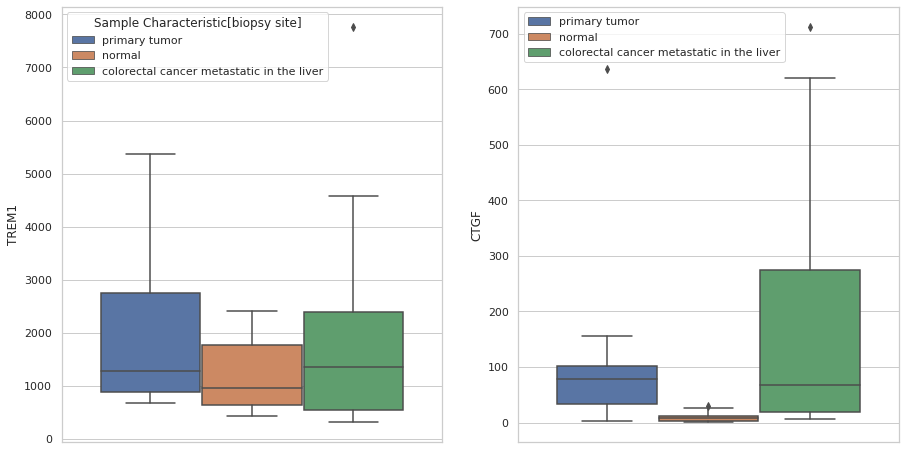

In [6]:
plt.figure(figsize = (15,8))
sns.set_theme(style="whitegrid")
ax1 = plt.subplot(1, 2, 1)
sns.boxplot(x=[""]*len(new_data['TREM1']),y = new_data['TREM1'], hue = new_data['Sample Characteristic[biopsy site]'], ax = ax1)
ax2 = plt.subplot(1, 2, 2)
sns.boxplot(x=[""]*len(new_data['CTGF']),y = new_data['CTGF'], hue = new_data['Sample Characteristic[biopsy site]'], ax = ax2)
plt.legend(loc ='upper left')
plt.show()

It can be assumed that CTGF gene is more informative for cancer diagnosis because healthy cells contain less CTGF (confidence interval) than tumor cells

In [6]:
gene_dict = raw_data.set_index('Gene ID').to_dict()['Gene Name']	


Creating a matrix with expression levels for control and primary tumor

In [7]:
rawCounts = raw_data[sampleData[(sampleData['Sample Characteristic[biopsy site]'] == 'normal') | (sampleData['Sample Characteristic[biopsy site]'] == 'primary tumor') ]['Run']]
rawCounts.index=raw_data['Gene ID']

In [8]:
rawCounts.head()

,SRR975551,SRR975552,SRR975553,SRR975554,SRR975555,SRR975556,SRR975557,SRR975558,SRR975559,SRR975560,...,SRR975578,SRR975579,SRR975580,SRR975581,SRR975582,SRR975583,SRR975584,SRR975585,SRR975586,SRR975587
Gene ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,6617,1352,1492,3390,1464,1251,207,1333,2126,1799,...,1008,310,2704,674,1121,1776,981,1185,2012,3190
ENSG00000000005,69,1,20,23,12,4,20,2,3,6,...,10,13,21,5,19,3,10,7,2,6
ENSG00000000419,2798,714,510,1140,1667,322,273,621,1031,677,...,271,213,783,268,467,452,419,473,607,1274
ENSG00000000457,486,629,398,239,383,290,164,452,172,229,...,243,159,324,257,360,409,310,430,248,314
ENSG00000000460,466,342,73,227,193,35,38,184,174,68,...,21,17,131,52,57,86,70,65,79,251


In [9]:
rawCounts_array = rawCounts.to_numpy()

In [10]:
rawCounts_array.shape

(65217, 37)

In [11]:
rawCounts_array

array([[6617, 1352, 1492, ..., 1185, 2012, 3190],
       [  69,    1,   20, ...,    7,    2,    6],
       [2798,  714,  510, ...,  473,  607, 1274],
       ...,
       [   0,    1,    0, ...,    1,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=int64)

Deleating small expressed genes:

In [12]:
big_enough = list(set((np.sum(rawCounts_array,axis=1) >5)*np.arange(rawCounts_array.shape[0])))
clear_data = rawCounts.iloc[big_enough]

In [13]:
clear_data.shape[0]

33356

In [14]:
rawCounts_array.shape[0]

65217

Almost half of genes were uninformative

In [15]:
clear_data_array = clear_data.to_numpy()
std_array = np.std(clear_data_array, axis=1)

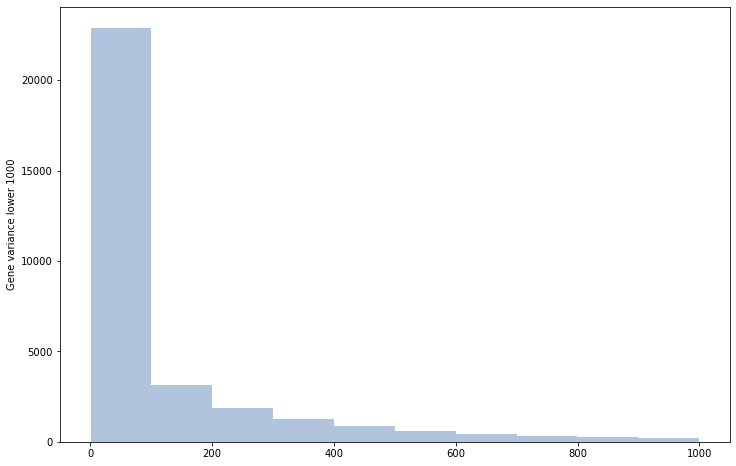

In [16]:
plt.figure(figsize = (12,8))
plt.hist(std_array[std_array<1000],bins = 10, color='lightsteelblue')
plt.ylabel('Gene variance lower 1000')
plt.show()

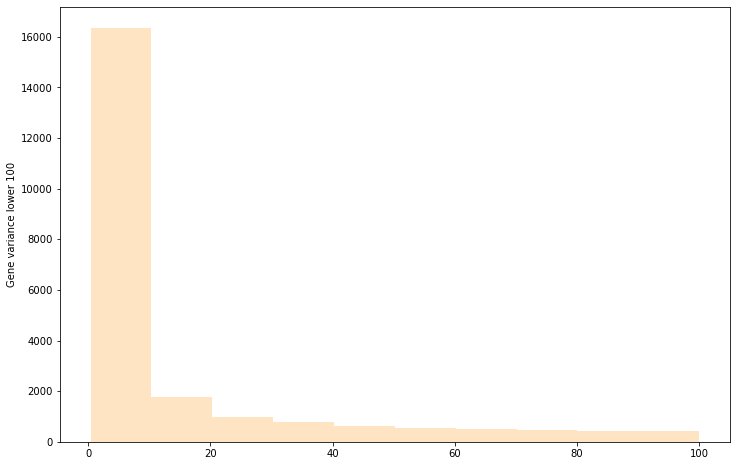

In [17]:
plt.figure(figsize = (12,8))
plt.hist(std_array[std_array<100],bins = 10, color='bisque')
plt.ylabel('Gene variance lower 100')
plt.show()

Let's take the 5000 genes with the highest variance

In [18]:
biggest_std_ind=np.argsort(std_array)[-5000::-1]

In [19]:
clear_data.iloc[biggest_std_ind].index

Index(['ENSG00000137960', 'ENSG00000165507', 'ENSG00000103496',
       'ENSG00000138031', 'ENSG00000168878', 'ENSG00000145715',
       'ENSG00000134108', 'ENSG00000165156', 'ENSG00000108511',
       'ENSG00000139726',
       ...
       'ENSG00000267393', 'ENSG00000231503', 'ENSG00000231255',
       'ENSG00000267144', 'ENSG00000231049', 'ENSG00000231047',
       'ENSG00000255428', 'ENSG00000267028', 'ENSG00000213328',
       'ENSG00000270140'],
      dtype='object', name='Gene ID', length=28357)

#### 2. Building a linear model

In [20]:
data_for_regr = new_data[(new_data['Sample Characteristic[biopsy site]'] == 'normal') | (new_data['Sample Characteristic[biopsy site]'] == 'primary tumor') ]
data_for_regr = data_for_regr.iloc[:,[0,3]]
typee=list((np.array(data_for_regr['Sample Characteristic[biopsy site]']) == 'primary tumor')*1)
data_for_regr.insert(2, 'Type',typee)

In [21]:
# control== 0
# primary tumour==1
X = np.array(data_for_regr['Type']).reshape(-1, 1)
y = np.array(data_for_regr['TREM1'])

In [22]:
model = LinearRegression().fit(X,y)


In [23]:
print(model.coef_)
print(model.intercept_)

[655.56725146]
1179.2105263157896


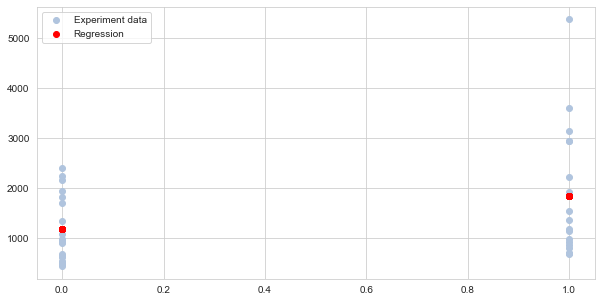

In [24]:
plt.figure(figsize = (10,5))
sns.set_style('whitegrid')
plt.scatter(X,y, color= 'lightsteelblue', label='Experiment data')
plt.scatter(X,model.predict(X), color= 'r', label='Regression')
plt.legend()
plt.show()

In [7]:
normal_names = list(sampleData[sampleData['Sample Characteristic[biopsy site]'] == 'normal']['Run'])
X=list(rawCounts)
for i in range(len(X)):
  if X[i] in set(normal_names):
    X[i]=0
  else:
    X[i]=1
X=np.array(X).reshape(-1, 1)

In [8]:
def get_gene_coef(data,X):
#y=kx+b
    k=[]
    bias=[]
    for i in tqdm(range(data.shape[0])):
      model = LinearRegression().fit(X,data.iloc[i])
      k.append(model.coef_[0])
      bias.append(model.intercept_)

    coef_df = pd.DataFrame(list(zip(k, bias)), columns =['k', 'b'])
    coef_df.index=data.index
    return coef_df

In [36]:
result = get_gene_coef(rawCounts,X)

100%|██████████| 65217/65217 [00:40<00:00, 1606.87it/s]


In [39]:
result.sort_values(by=['k'])

,k,b
Gene ID,,
ENSG00000198804,-133289.535088,610757.368421
ENSG00000210082,-74949.023392,275586.578947
ENSG00000211890,-71294.675439,94575.842105
ENSG00000162896,-55821.242690,118070.631579
ENSG00000132465,-52888.391813,74839.947368
...,...,...
ENSG00000102837,21929.415205,8612.473684
ENSG00000164692,25453.959064,7183.263158
ENSG00000168542,34219.365497,11489.578947


#### 3. Results

In the models above 1 meant tumor tissue and 0 -- normal. Extremelly positive value of coefficient in linear model means tha this gene expresses in tumor tissue much more than in normal. These genes can be related with cancer. Top 5 are:



ENSG00000198804 -  [MT-CO1](https://https://www.genecards.org/cgi-bin/carddisp.pl?gene=MT-CO1)

ENSG00000210082 - [MT-RNR2](https://https://www.genecards.org/cgi-bin/carddisp.pl?gene=MT-RNR2&keywords=ENSG00000210082)

ENSG00000211890 - [IGHA2](https://www.genecards.org/cgi-bin/carddisp.pl?gene=IGHA2&keywords=ENSG00000211890) 

ENSG00000162896 - [PIGR](https://https://www.genecards.org/cgi-bin/carddisp.pl?gene=PIGR&keywords=ENSG00000162896)

ENSG00000132465 - [JCHAIN](https://https://www.genecards.org/cgi-bin/carddisp.pl?gene=JCHAIN&keywords=ENSG00000132465)

Функции генов по ссылке

#### 5. Volcano plot

In [9]:
def p_value(gene_id, group_1, group_2):
    
    return sps.ttest_rel(group_1, group_2)[0]

In [10]:
def fold_change(gene_id, group_1, group_2):
    
    return (np.mean(group_2)+ 0.0000001)/(np.mean(group_1) + 0.0000001)

In [11]:
normal_names = list(sampleData[sampleData['Sample Characteristic[biopsy site]'] == 'normal']['Run'])
tumor_names = list(sampleData[sampleData['Sample Characteristic[biopsy site]'] == 'primary tumor']['Run'])
normal_data = rawCounts[normal_names]
tumor_data = rawCounts[tumor_names]

In [12]:
genes=rawCounts.index
p_val=[]
for i in tqdm(range(len(genes))):
  group1 = list(normal_data.loc[genes[i]])
  group2 = list(tumor_data.loc[genes[i]])
  l = min(len(group1),len(group2))
  p_val.append(sps.ttest_rel  (group1[:l],group2[:l])[1])


100%|██████████| 65217/65217 [00:56<00:00, 1156.83it/s]


In [13]:
p_corrected = multipletests(p_val, alpha=0.1, method='holm')

In [14]:
indexes = np.argsort(p_corrected[1])[:500]

fold_list = []
for j in indexes:
  fold_list.append(fold_change(genes[j], normal_data.loc[genes[j]], tumor_data.loc[genes[j]]))

In [15]:
X = np.log2(fold_list[:500])
y=-np.log10(np.sort(p_corrected[1])[:500])

In [16]:
X_d = []
X_u = []
y_d = []
y_u=[]
i_list = []
p_p = -np.log10(0.05)
for i in range(500):
  if (X[i]<-1) and (y[i]>p_p):
    X_d.append(X[i])
    y_d.append(y[i])
    i_list.append(i)
  elif (X[i]>1) and (y[i]>p_p):
    X_u.append(X[i])
    y_u.append(y[i])


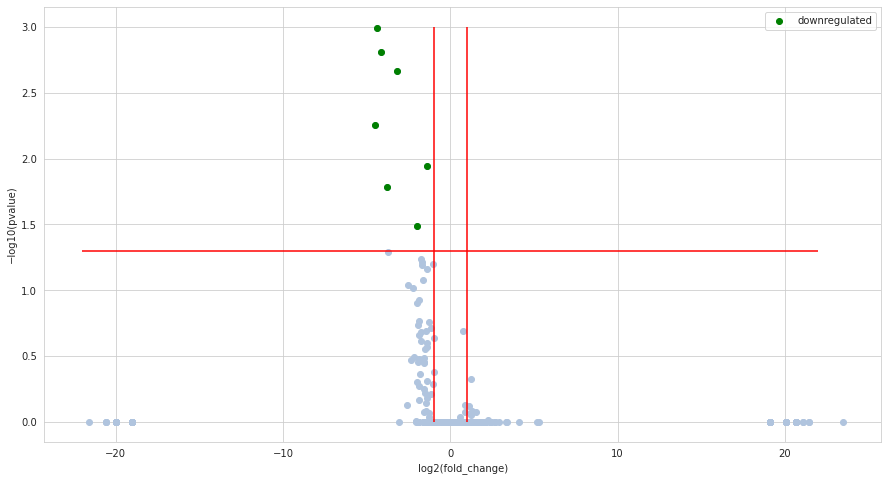

In [17]:
plt.figure(figsize=(15,8))
sns.set_style('whitegrid')
plt.scatter(np.log2(fold_list[:500]), -np.log10(np.sort(p_corrected[1])[:500]),color= 'lightsteelblue')
plt.vlines(-1,0,3, color='r')
plt.vlines(1,0,3,color='r')
plt.hlines(-np.log10(0.05),-22,22,color='r')
plt.scatter(X_d,y_d, color='g', label='downregulated')
plt.ylabel('−log10(pvalue)')
plt.xlabel('log2(fold_change)')
plt.legend()
plt.show()

In [18]:
genes[indexes[i_list]]

Index(['ENSG00000183034', 'ENSG00000142959', 'ENSG00000269404',
       'ENSG00000182938', 'ENSG00000228307', 'ENSG00000168748',
       'ENSG00000253701'],
      dtype='object', name='Gene ID')

In [19]:
down_gene = genes[indexes[i_list]]
for gene in down_gene:
  print(gene_dict[gene])

OTOP2
BEST4
SPIB
OTOP3
OR2S1P
CA7
nan


In [25]:
relev_ind = list(set(((X>-8) & (X<8))*np.arange(500)))

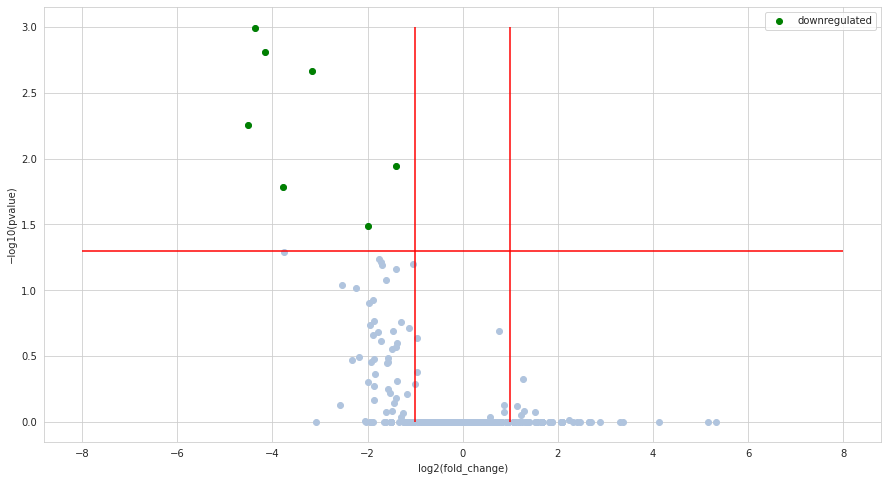

In [26]:
plt.figure(figsize=(15,8))
sns.set_style('whitegrid')
plt.scatter(X[relev_ind], y[relev_ind],color= 'lightsteelblue')
plt.vlines(-1,0,3, color='r')
plt.vlines(1,0,3,color='r')
plt.hlines(-np.log10(0.05),-8,8,color='r')
plt.scatter(X_d,y_d, color='g', label='downregulated')
plt.ylabel('−log10(pvalue)')
plt.xlabel('log2(fold_change)')
plt.legend()
plt.show()

Here we can also see that OTOP2
BEST4
SPIB
OTOP3
OR2S1P
CA7 are statistically significantly expressed in smaller amounts in cancer cells